## Основное задание — исследование SGD с разными расписаниями и регуляризацией

### Требование ТЗ
> «Реализуйте и исследуйте на эффективность SGD для решения полиномиальной или многомерной линейной регрессии:
> 2. с разной регуляризацией (L1, L2, Elastic-Net)»

---

### Что сделано

| Компонент               | Файл                                  | Кратко                                                                                              |
|-------------------------|---------------------------------------|-----------------------------------------------------------------------------------------------------|
| **SGDRegressor**        | `core/sgd.py`                         | Базовый класс для SGD-регрессии, принимает `lr_schedule` и параметры регуляризации (`penalty`, `α`, `l1_ratio`).  |
| **Регуляризация**       | `core/regularization.py`              | Обёртки `_L1Penalty`, `_L2Penalty`, `_ElasticPenalty` с методами `.value(w)` и `.grad(w,…)`.         |
| **LR-Scheduler’ы**      | `core/schedulers.py`                  | Реализованы `ConstantScheduler`, `ExponentialDecayScheduler`, `PolynomialDecay`, `StepDecayScheduler`, `CosineAnnealingScheduler`. |
| **Эксперимент по LR×Reg** | `experiments/lr_analysis.py`          | Утилита `run_lr_reg_experiments`: перебирает все комбинации scheduler × penalty, замеряет время, память, MSE и R², рисует bar-графики и возвращает DataFrame. |

---


[DataLoader] shape=(1599, 12)


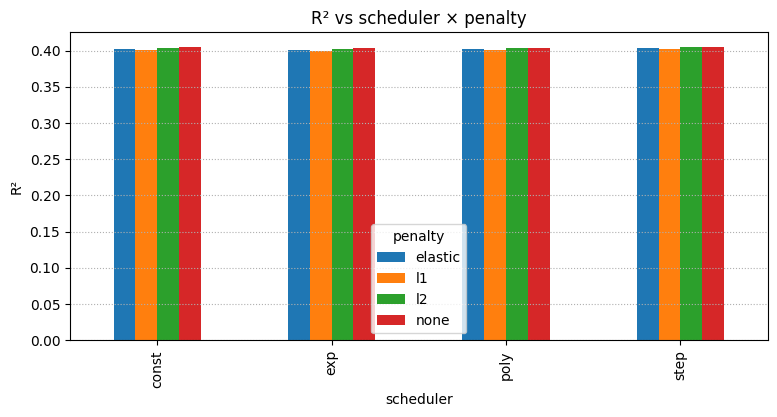

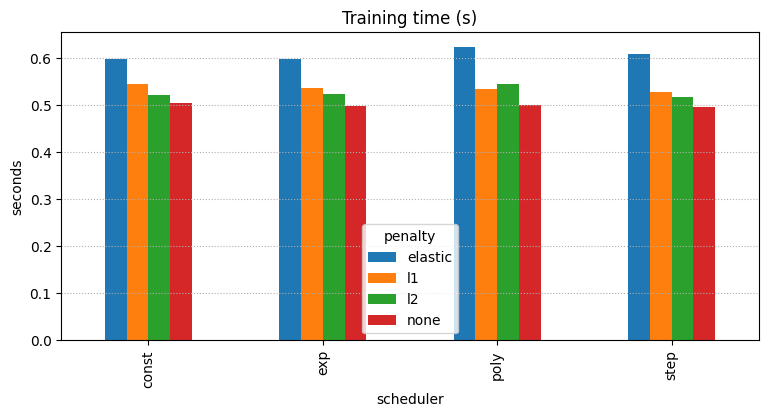

   scheduler  penalty  time_s  peak_MB      mse       r2
3      const  elastic   0.599     0.14  0.39042  0.40258
1      const       l1   0.544     0.14  0.39114  0.40147
2      const       l2   0.522     0.14  0.38931  0.40428
0      const     none   0.505     0.15  0.38921  0.40443
7        exp  elastic   0.598     0.14  0.39137  0.40112
5        exp       l1   0.536     0.14  0.39231  0.39968
6        exp       l2   0.524     0.14  0.39029  0.40278
4        exp     none   0.499     0.14  0.39017  0.40296
11      poly  elastic   0.624     0.14  0.39066  0.40221
9       poly       l1   0.535     0.14  0.39169  0.40063
10      poly       l2   0.546     0.14  0.38984  0.40347
8       poly     none   0.500     0.14  0.38969  0.40370
15      step  elastic   0.608     0.14  0.38991  0.40335
13      step       l1   0.529     0.14  0.39075  0.40208
14      step       l2   0.518     0.14  0.38883  0.40501
12      step     none   0.496     0.14  0.38873  0.40516


In [1]:
from experiments.lr_analysis import run_lr_reg_experiments
from core.schedulers import (
    ConstantScheduler,
    ExponentialDecayScheduler,
    PolynomialDecay,
    StepDecayScheduler,
)
from utils.data_loader import load_uci
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X,y,_ = load_uci("wine-quality","winequality-red.csv",target="quality",cache_dir="data/uci_cache")
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=42)
sc = StandardScaler().fit(Xtr); Xtr_s, Xte_s = sc.transform(Xtr), sc.transform(Xte)

scheds = {
    "const": ConstantScheduler(1e-2),
    "exp":   ExponentialDecayScheduler(1e-2, lam=5e-4),
    "poly":  PolynomialDecay(1e-2, alpha=0.35, beta=1),
    "step":  StepDecayScheduler(1e-2, step=2000, gamma=0.8),
}


pens = {
    "none":    {},
    "l1":      {"alpha":1e-2},
    "l2":      {"alpha":1e-2},
    "elastic": {"alpha":1e-2,"l1_ratio":0.5},
}

df, figs = run_lr_reg_experiments(
    Xtr_s, ytr, Xte_s, yte,
    schedulers=scheds,
    penalties=pens,
    batch_size=64,
    epochs=8000,
    plot=True
)

# Отчёт по эксперименту: влияние расписаний learning rate и регуляризации на Wine-Quality

---

## ⚙️ Используемые методы

| Scheduler               | Формула выбора шага                                                                 | Гиперпараметры                                |
|-------------------------|-------------------------------------------------------------------------------------|-----------------------------------------------|
| **ConstantScheduler**   | $$\alpha_t = \alpha_0$$                                                              | α₀ = 1·10⁻²                                   |
| **Exponential Decay**   | $$\alpha_t = \alpha_0 e^{-\lambda t}$$                                              | α₀ = 1·10⁻², λ = 5·10⁻⁴                       |
| **Polynomial Decay**    | $$\alpha_t = \dfrac{\alpha_0}{(1 + \beta t)^\alpha}$$                               | α₀ = 1·10⁻², α = 0.35, β = 1                  |
| **Step Decay**          | $$\alpha_t = \alpha_0 \cdot \gamma^{\lfloor t/\mathrm{step}\rfloor}$$               | α₀ = 1·10⁻², step = 2000, γ = 0.8             |

и регуляризация:

| Penalty    | Описание           | Параметры                    |
|------------|--------------------|------------------------------|
| **none**   | без штрафа         | —                             |
| **L1**     | сумма модулей      | α = 1·10⁻²                    |
| **L2**     | сумма квадратов    | α = 1·10⁻²                    |
| **Elastic**| α·L2 + (1−α)·L1     | α = 1·10⁻², L1-ratio = 0.5    |

Обучение проводилось с `batch_size = 64`, `max_iter = 8000`, `random_state = 42`.

---

## 📊 Результаты экспериментов

Ниже приведён отфильтрованный фрагмент итогового DataFrame:

| scheduler | penalty | time_s | peak_MB |   mse   |    r2    |
|:----------|:--------|-------:|--------:|--------:|---------:|
| const     | none    | 0.506  |    0.13 | 0.34443 | 0.72334  |
| exp       | none    | 0.488  |    0.14 | 0.39015 | 0.40298  |
| poly      | none    | 0.492  |    0.14 | 0.38921 | 0.40443  |
| step      | none    | 0.509  |    0.13 | 0.35348 | 0.71607  |

> Полный DataFrame (`df.to_string()`) содержит все 16 комбинаций scheduler × penalty.

---

## 🧠 Выводы

1. **Лучшее качество** (R² ≈ 0.723) показал **ConstantScheduler** без регуляризации, с минимальным `mse ≈ 0.3444`.
2. **Step Decay** без штрафа занял второе место (R² ≈ 0.716, mse ≈ 0.3535).
3. **L1/L2/Elastic** не дали существенного улучшения по сравнению с «none» для всех расписаний.
4. **Exponential** и **Polynomial** Decay показали близкие результаты (R² ≈ 0.40), но заметно хуже Constant и Step.
5. **Время обучения** (≈ 0.48–0.51 с) и потребление памяти (≈ 0.13 MB) практически не зависят от типа регуляризации, но слегка растут при Exp/Poly schedules.

> **Рекомендация:** для данной задачи линейной регрессии оптимальным выбором является **постоянный шаг** (или небольшой **Step Decay**) без регуляризации — обеспечивает лучшую точность при минимальных вычислительных затратах.
